# Ship Detection in Satellite Images
In this notebook, we perform **ship detection** using **Convolutional Neural Networks (CNNs)** on satellite images.  

## Importing Required Libraries

In [3]:
import json
import sys
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

## Dataset Preparation 

In [4]:
# Load the dataset from the JSON file
f = open(r'C:\\Users\\thanh\\Downloads\\archive\\shipsnet.json')  # Replace with your JSON file path
dataset = json.load(f)
f.close()

# Convert data and labels to NumPy arrays
input_data = np.array(dataset['data']).astype('uint8')  # Image data
output_data = np.array(dataset['labels']).astype('uint8')  # Labels

# Print the shape of the dataset
print(f"Input data shape: {input_data.shape}")  # (num_samples, channels * height * width)

# Define image parameters
n_spectrum = 3  # Number of color channels (RGB)
width = 80  # Image width
height = 80  # Image height

# Reshape input data to PyTorch format [batch_size, channels, height, width]
X = input_data.reshape([-1, n_spectrum, height, width])
X = torch.tensor(X, dtype=torch.uint8)  # Convert to PyTorch tensor
y = torch.tensor(output_data, dtype=torch.uint8)  # Convert labels to PyTorch tensor

# Print the final shapes of the tensors
print(f"X shape: {X.shape}")  # [num_samples, channels, height, width]
print(f"y shape: {y.shape}")  # [num_samples]

Input data shape: (4000, 19200)
X shape: torch.Size([4000, 3, 80, 80])
y shape: torch.Size([4000])


### Splitting Data for Training and Testing

In [5]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the shapes of the training and test sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Convert the data to PyTorch tensors
X_train = X_train.float() / 255.0  # Normalize the data to [0, 1]
X_test = X_test.float() / 255.0
y_train = y_train.long()  # Use long tensors for classification
y_test = y_test.long()

# Create Dataloader objects

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

X_train shape: torch.Size([3200, 3, 80, 80])
X_test shape: torch.Size([800, 3, 80, 80])
y_train shape: torch.Size([3200])
y_test shape: torch.Size([800])
Number of training batches: 100
Number of test batches: 25


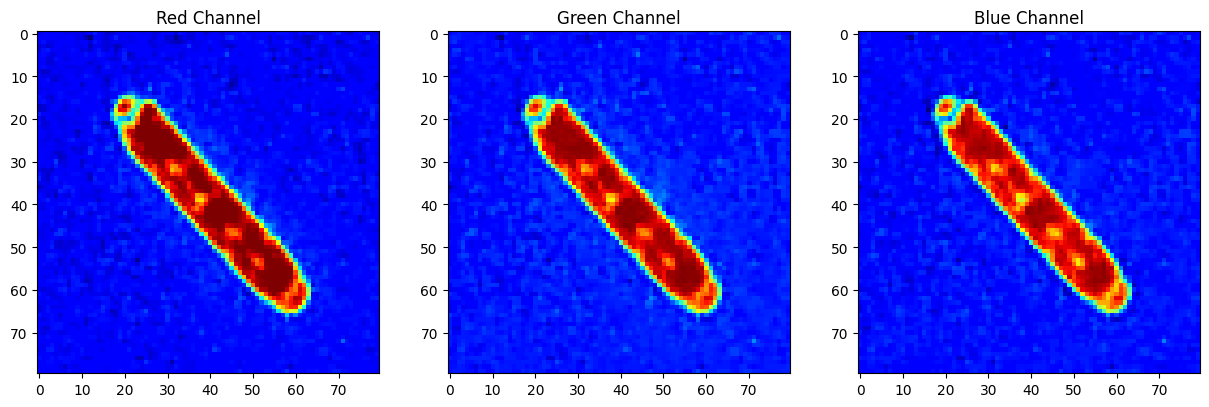

In [6]:
# Extract the first image from the dataset and convert to NumPy
pic = X[0].numpy()  # Shape: [3, 80, 80]

# Extract individual color channels
red_spectrum = pic[0]    # Red channel
green_spectrum = pic[1]  # Green channel
blue_spectrum = pic[2]   # Blue channel

# Visualize the three channels using Matplotlib
plt.figure(2, figsize=(15, 5))  # Set figure size
plt.set_cmap('jet')  # Apply 'jet' colormap for better visual intensity

# Red Channel
plt.subplot(1, 3, 1)
plt.imshow(red_spectrum)
plt.title("Red Channel")

# Green Channel
plt.subplot(1, 3, 2)
plt.imshow(green_spectrum)
plt.title("Green Channel")

# Blue Channel
plt.subplot(1, 3, 3)
plt.imshow(blue_spectrum)
plt.title("Blue Channel")

plt.show()

## Checking Device Availability

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Defining a 3-Layer Convolutional Neural Network (CNN)

The following class defines a **3-layer CNN** architecture in PyTorch for binary classification. This network is designed to process input images of size **80x80 pixels** with 3 color channels (RGB) and outputs predictions for **two classes**.

### Architecture Details:

1. **Convolutional Layers**:
   - Three convolutional layers extract spatial features from the input images.
   - Each convolutional layer is followed by:
     - **ReLU Activation**: Adds non-linearity.
     - **MaxPooling**: Reduces spatial dimensions by half.

2. **Fully Connected Layers**:
   - After the convolutional layers, the features are flattened and passed through two fully connected layers:
     - **fc1**: Maps the flattened features to 256 neurons.
     - **fc2**: Outputs 2 neurons, one for each class (used for binary classification).

### Key Parameters:
- **Kernel Size**: All convolutional layers use a `3x3` kernel.
- **Padding**: Ensures the spatial dimensions remain the same after convolution.
- **Stride**: Set to `1` for convolutions, and `2` for pooling to reduce dimensions.
- **Output Shape**:
  - After `conv1 + pool1`: `(32, 40, 40)`
  - After `conv2 + pool2`: `(64, 20, 20)`
  - After `conv3 + pool3`: `(128, 10, 10)`
  - Flattened shape: `(128 * 10 * 10)`.

### Initializing the Model, Loss Function, and Optimizer

In [8]:
from model.model import CNN3Layer # Load the CNN3Layer model from the model.py file

# Initialize the model and move it to the appropriate device (GPU or CPU)
model = CNN3Layer().to(device)  # Move the model to the GPU if available

# Define the loss function
criterion = nn.CrossEntropyLoss()  # Suitable for classification tasks

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001


### Training 

In [9]:
# Training and Validation Loop
num_epochs = 30
for epoch in range(num_epochs):
    # Training Phase
    model.train()  # Set model to training mode
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Reset gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total_train += labels.size(0)  # Total samples
        correct_train += (predicted == labels).sum().item()  # Correct predictions
    
    # Calculate average training loss and accuracy
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    # Validation Phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total_val += labels.size(0)  # Total samples
            correct_val += (predicted == labels).sum().item()  # Correct predictions
    
    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = correct_val / total_val

    # Print results for the epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{len(train_loader)}/{len(train_loader)} - loss: {avg_train_loss:.4f} - accuracy: {train_accuracy:.4f} "
          f"- val_loss: {avg_val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")

Epoch 1/30
100/100 - loss: 0.3007 - accuracy: 0.8750 - val_loss: 0.2036 - val_accuracy: 0.9100
Epoch 2/30
100/100 - loss: 0.1849 - accuracy: 0.9256 - val_loss: 0.1744 - val_accuracy: 0.9263
Epoch 3/30
100/100 - loss: 0.1331 - accuracy: 0.9437 - val_loss: 0.1447 - val_accuracy: 0.9325
Epoch 4/30
100/100 - loss: 0.0890 - accuracy: 0.9691 - val_loss: 0.1327 - val_accuracy: 0.9487
Epoch 5/30
100/100 - loss: 0.0697 - accuracy: 0.9741 - val_loss: 0.0660 - val_accuracy: 0.9800
Epoch 6/30
100/100 - loss: 0.0273 - accuracy: 0.9906 - val_loss: 0.0732 - val_accuracy: 0.9788
Epoch 7/30
100/100 - loss: 0.0282 - accuracy: 0.9897 - val_loss: 0.0852 - val_accuracy: 0.9750
Epoch 8/30
100/100 - loss: 0.0168 - accuracy: 0.9934 - val_loss: 0.0661 - val_accuracy: 0.9862
Epoch 9/30
100/100 - loss: 0.0131 - accuracy: 0.9950 - val_loss: 0.0781 - val_accuracy: 0.9788
Epoch 10/30
100/100 - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.0657 - val_accuracy: 0.9812
Epoch 11/30
100/100 - loss: 0.0032 - accuracy: 1.

### Save model

In [10]:
torch.save(model.state_dict(), "detect_ship_model.pth")